In [222]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import csv
import pandas as pd
import torch
import torch.nn.functional as F
import dgl
import numpy as np
from community import community_louvain
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch import optim
from dgl.nn import GraphConv

In [247]:
def normalize(n, minVal, maxVal, leftBorder, rightBorder):
    normalized = leftBorder + (n - minVal) * (rightBorder - leftBorder) / (maxVal - minVal)
    return normalized

def name_mapping(university):
    dict = {
        'МГУ': 0,
        'Университет ИТМО': 1,
        'НИУ ВШЭ (ГУ-ВШЭ)': 2,
        'Первый МГМУ им. И. М. Сеченова (Сеченовский Университет)': 3,
        'МАИ': 4,
        'МГИМО МИД России': 5,
        'МГТУ им. Н. Э. Баумана (бывш. МВТУ)': 6,
        'НИЯУ МИФИ': 7,
        'МТУСИ': 8,
        'МФТИ (Физтех)': 9,
        'НИУ МЭИ': 10,
        'РЭУ им. Г. В. Плеханова': 11,
        'РУДН': 12,
        'ПНИПУ (бывш. ПГТУ)': 13,
        'ПГНИУ (ПГУ)': 14,
        'РТУ МИРЭА': 15,
        'Не связана': 16,
    }

    return dict[university]

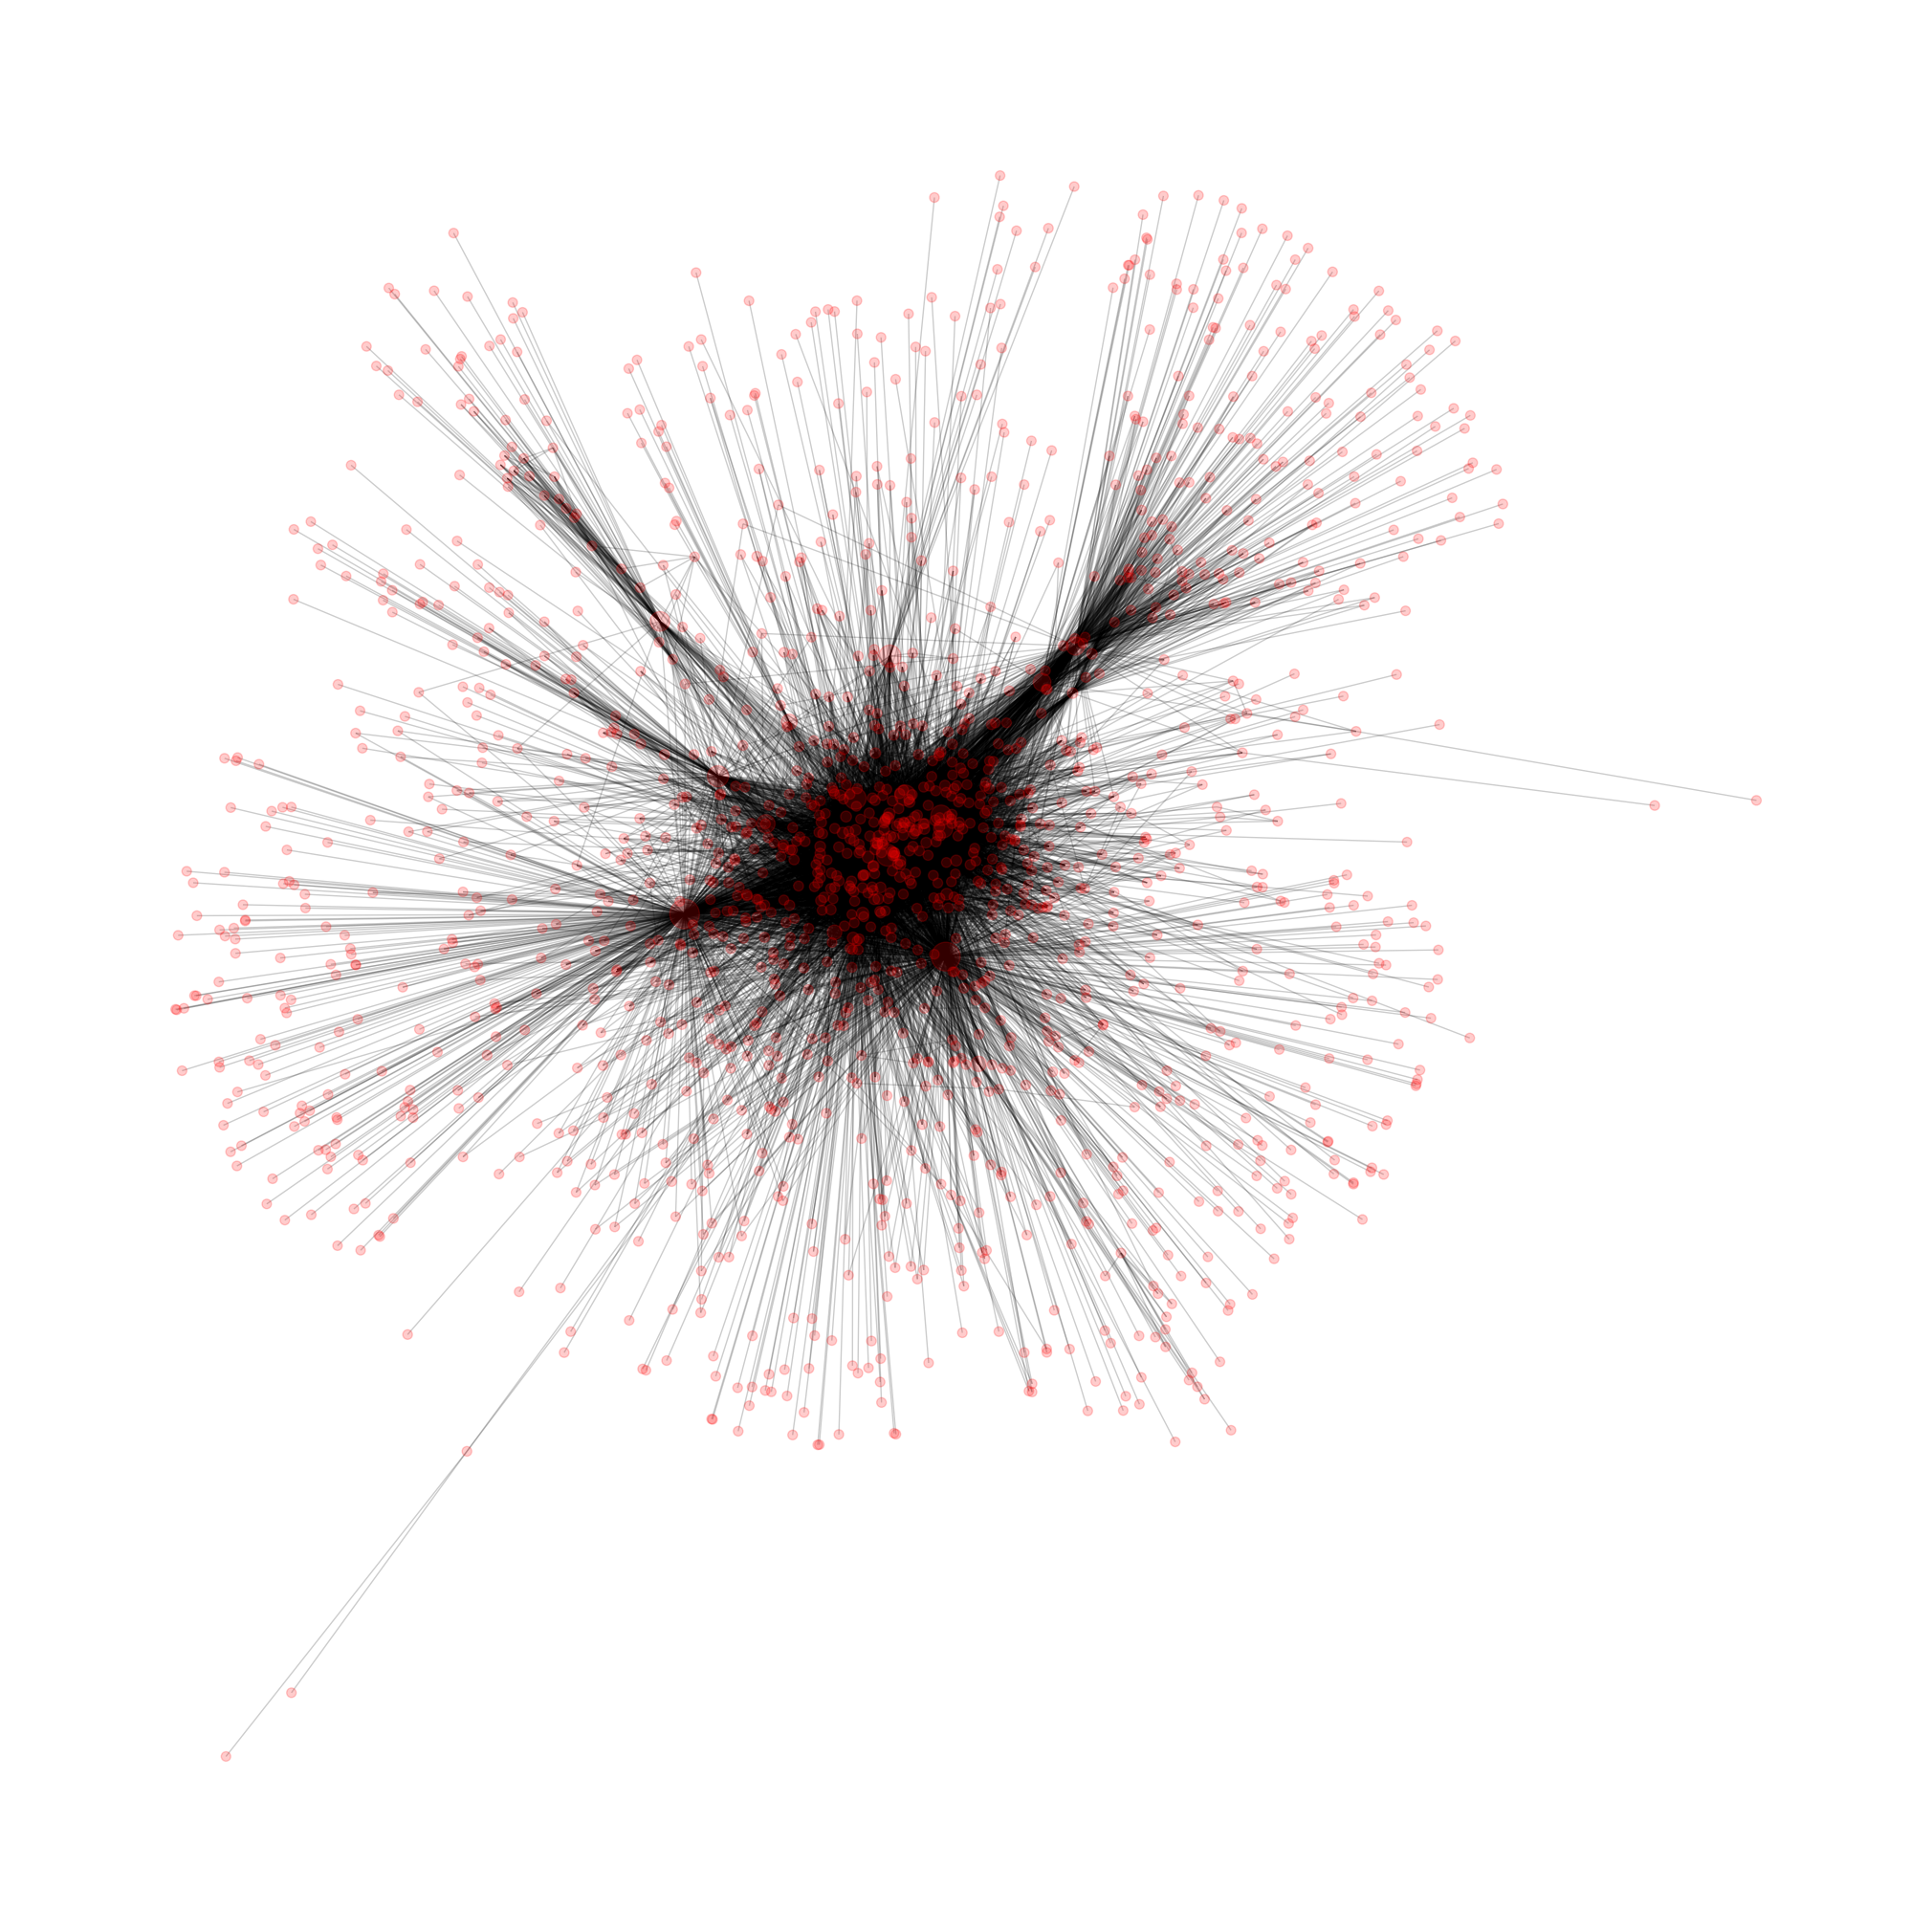

In [224]:
G = nx.Graph(directed = False)
min_q = sys.maxsize
max_q = 0

with open('dataInfo/nodes.csv', newline='', encoding='utf-8') as csvfile:
    csvreaderNode = csv.reader(csvfile, delimiter=";")
    next(csvreaderNode)
    for row in csvreaderNode:
         G.add_node(int(row[0]), name=row[2], quantity=int(row[3]))
         min_q = min(min_q, int(row[3]))
         max_q = max(max_q, int(row[3]))

with open('dataInfo/edges.csv', newline='', encoding='utf-8') as csvfile:
    csvreaderEdge = csv.reader(csvfile, delimiter=";")
    next(csvreaderEdge)
    for row in csvreaderEdge:
        G.add_edge(int(row[0]), int(row[1]), weight=int(row[2]))

G.remove_nodes_from([212768340, 197864572, 207167398, 186112991,194022878])
G.remove_nodes_from(list(nx.isolates(G)))

sizes = [normalize(G.nodes[node]['quantity'], min_q, max_q, 500, 50) for node in G.nodes()]

pos = nx.spring_layout(G)
plt.figure(figsize = (20, 20))
nx.draw(G, node_size=sizes, alpha=0.2, node_color='red')

plt.show()

Community quantity: 7


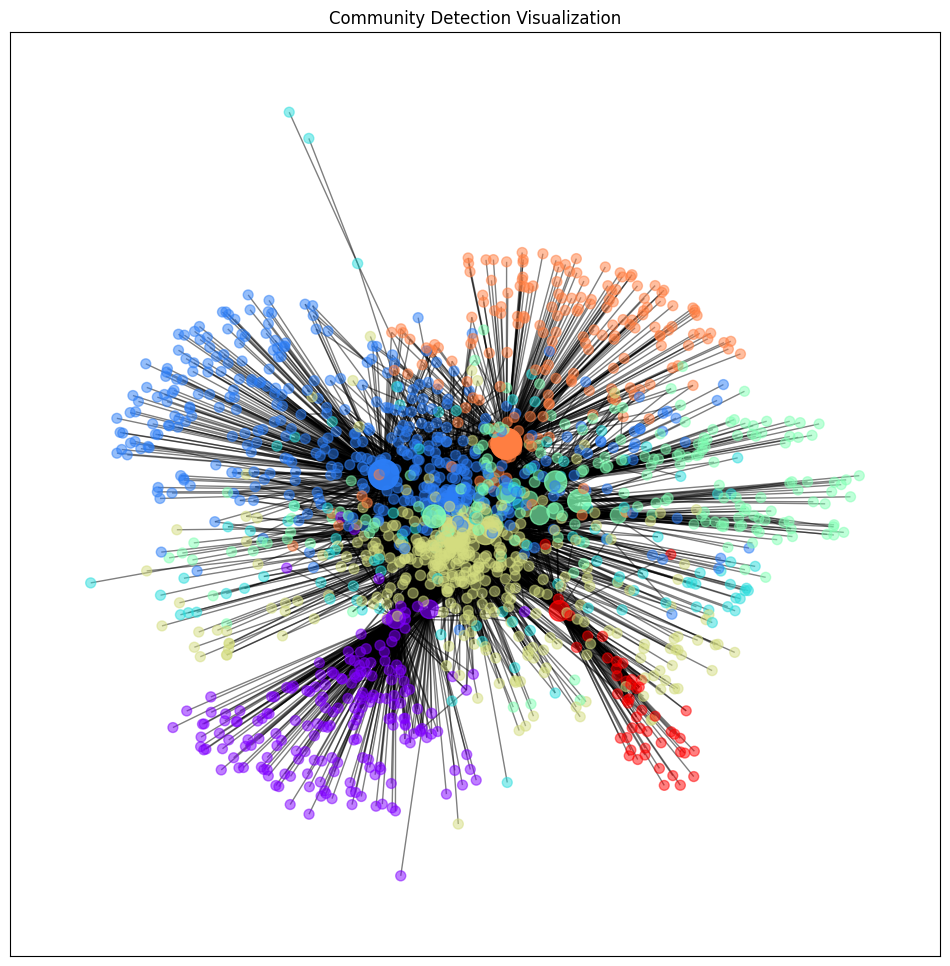

In [248]:
partition = community_louvain.best_partition(G, weight="weight")

for node, community in partition.items():
    G.nodes[node]['community'] = community
    
pos = nx.spring_layout(G)

colors = [partition[node] for node in G.nodes()]
sizes =  [normalize(G.nodes[node]['quantity'], min_q, max_q, 50, 500) for node in G.nodes()]
alpha =  [normalize(G.nodes[node]['quantity'], min_q, max_q, 0.5, 1) for node in G.nodes()]

print("Community quantity: "+str(len(set(partition.values()))))

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap=plt.cm.rainbow, alpha=alpha)
plt.title('Community Detection Visualization')
plt.show()

In [261]:
nodes = pd.read_csv('dataInfo/nodes.csv', delimiter=';')
edges = pd.read_csv('dataInfo/edges.csv', delimiter=';')


perameters = ['sub_quantity','open_sub_quantity',
               'MGU_quantity','MIFI_quantity','HSE_quantity',
               'SECH_quantity','MEI_quantity','MGIMO_quantity',
               'PNIPU_quantity','MIREA_quantity','MTUSI_quantity',
               'MAI_quantity','PGNIU_quantity','MFTI_quantity',
               'RUDN_quantity','ITMO_quantity','REU_quantity','MGTU_quantity']
target = 'university'

university_filled = nodes[nodes[target].notna()]

X = university_filled[perameters]
y = university_filled[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set: {:.2f}%".format(accuracy * 100))

df_unfilled = nodes[nodes[target].isna()]
X_unfilled = df_unfilled[perameters]
nodes.loc[nodes[target].isna(), target] = model.predict(X_unfilled)

Accuracy on validation set: 89.02%


c:\Users\Alex-admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


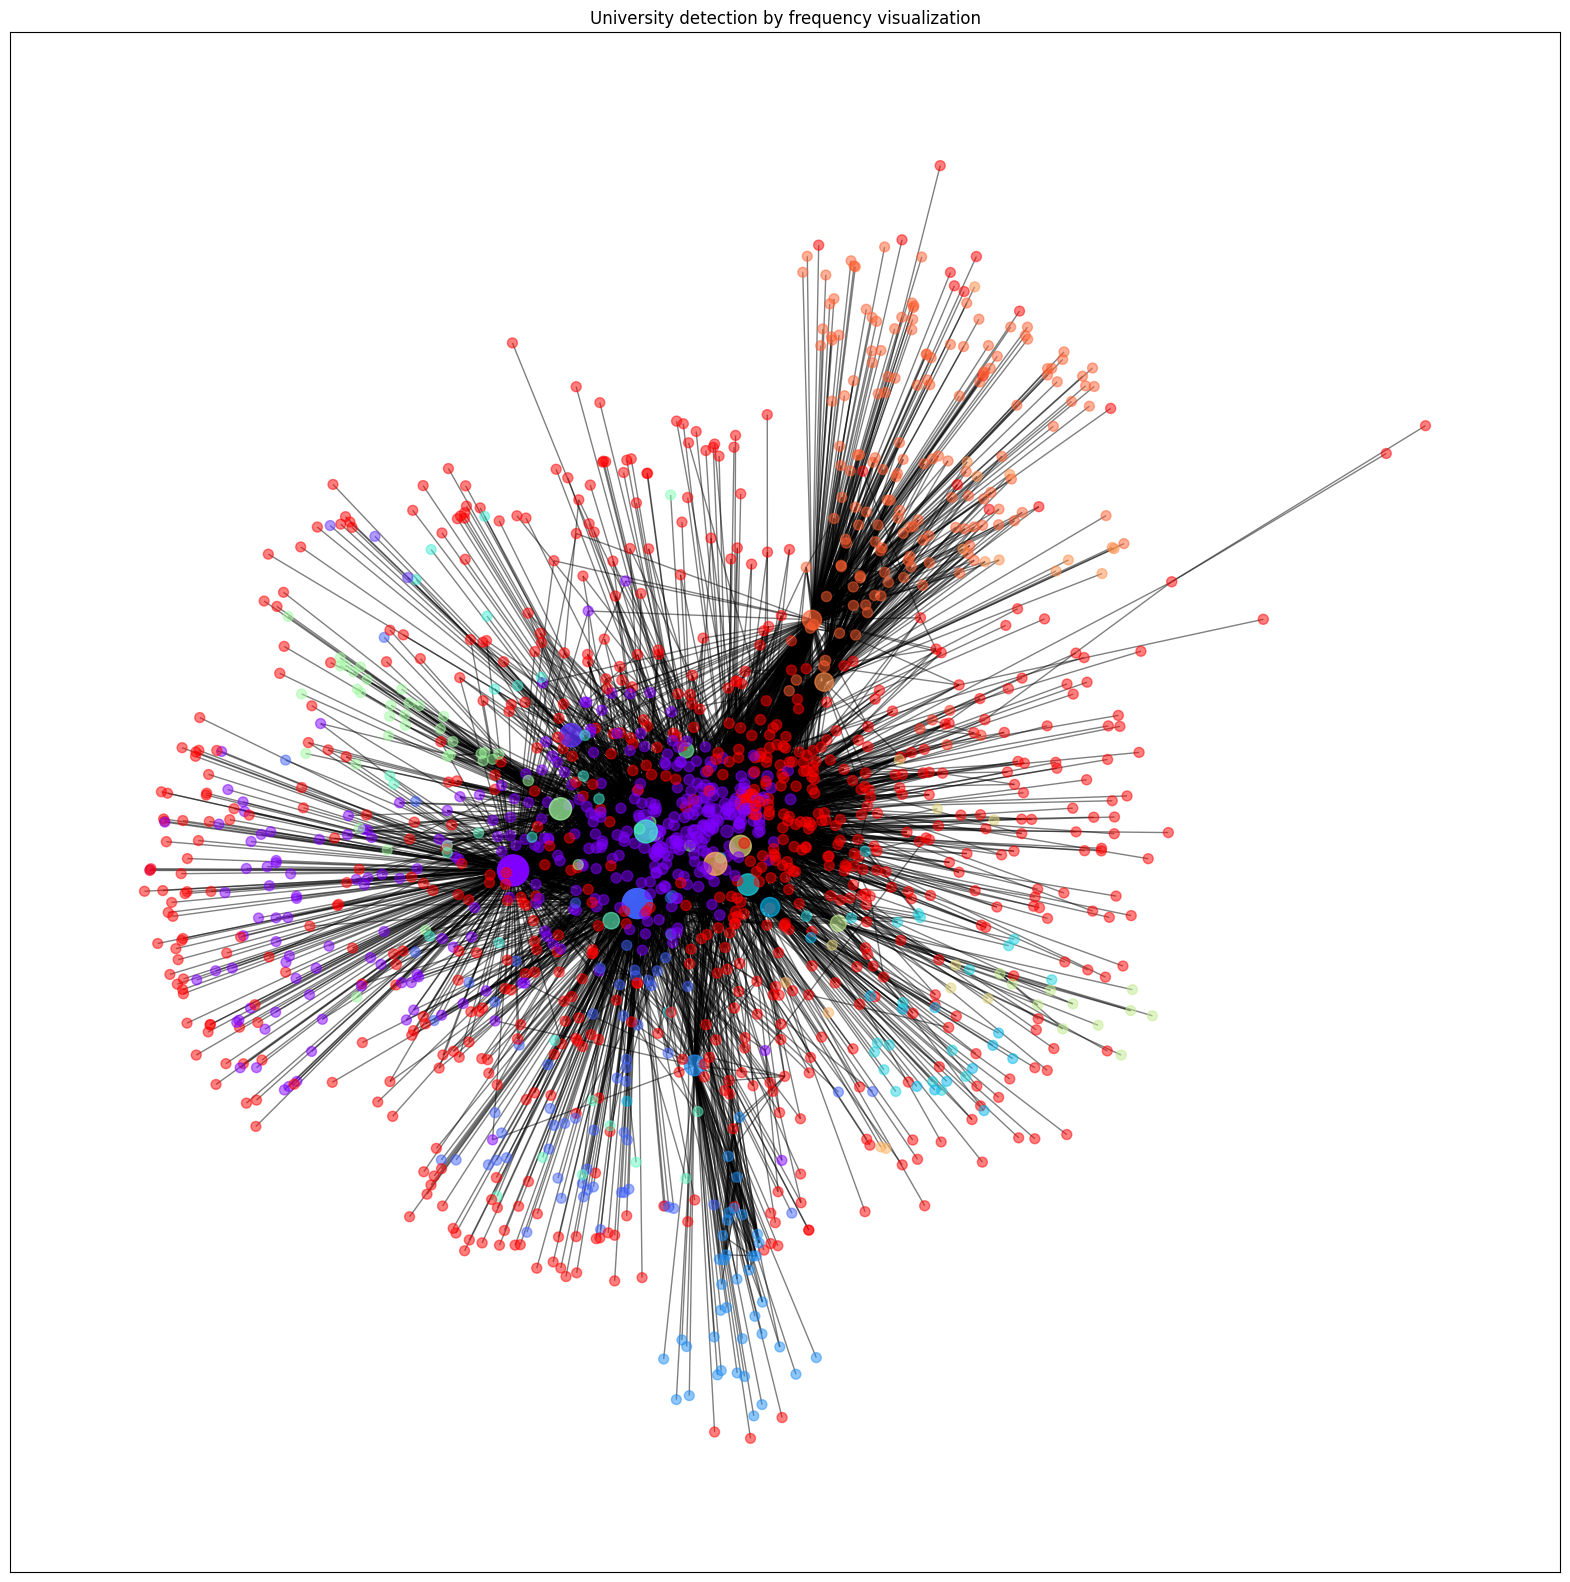

In [262]:
def build_graph(node_df, edge_df):

    G = nx.Graph()
    for _, row in node_df.iterrows():  
        G.add_node(row['id'], name = row['name'], university=row['university'], is_main_group=int(row['is_main_group_int']), sub_quantity=int(row['sub_quantity']))

    for _, row in edge_df.iterrows():
        if row['VKGroup_1'] in G.nodes and row['VkGroup_2'] in G.nodes:
            G.add_edge(row['VKGroup_1'], row['VkGroup_2'], weight=int(row['Quantity']))

    return G

g = build_graph(nodes, edges)
g.remove_nodes_from([212768340, 197864572, 207167398, 186112991,194022878])
g.remove_nodes_from(list(nx.isolates(g)))

pos = nx.spring_layout(g)

min_q = nodes['sub_quantity'].min()
max_q = nodes['sub_quantity'].max()

colors = [name_mapping(g.nodes[node]['university']) for node in g.nodes()]
sizes =  [normalize(g.nodes[node]['sub_quantity'], min_q, max_q, 50, 500) for node in g.nodes()]
alpha =  [normalize(g.nodes[node]['sub_quantity'], min_q, max_q, 0.5, 1) for node in g.nodes()]

plt.figure(figsize=(20, 20))
nx.draw_networkx_edges(g, pos, alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_size=sizes, node_color=colors, cmap=plt.cm.rainbow, alpha=alpha)
plt.title('University detection by frequency visualization')
plt.show()


c:\Users\Alex-admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


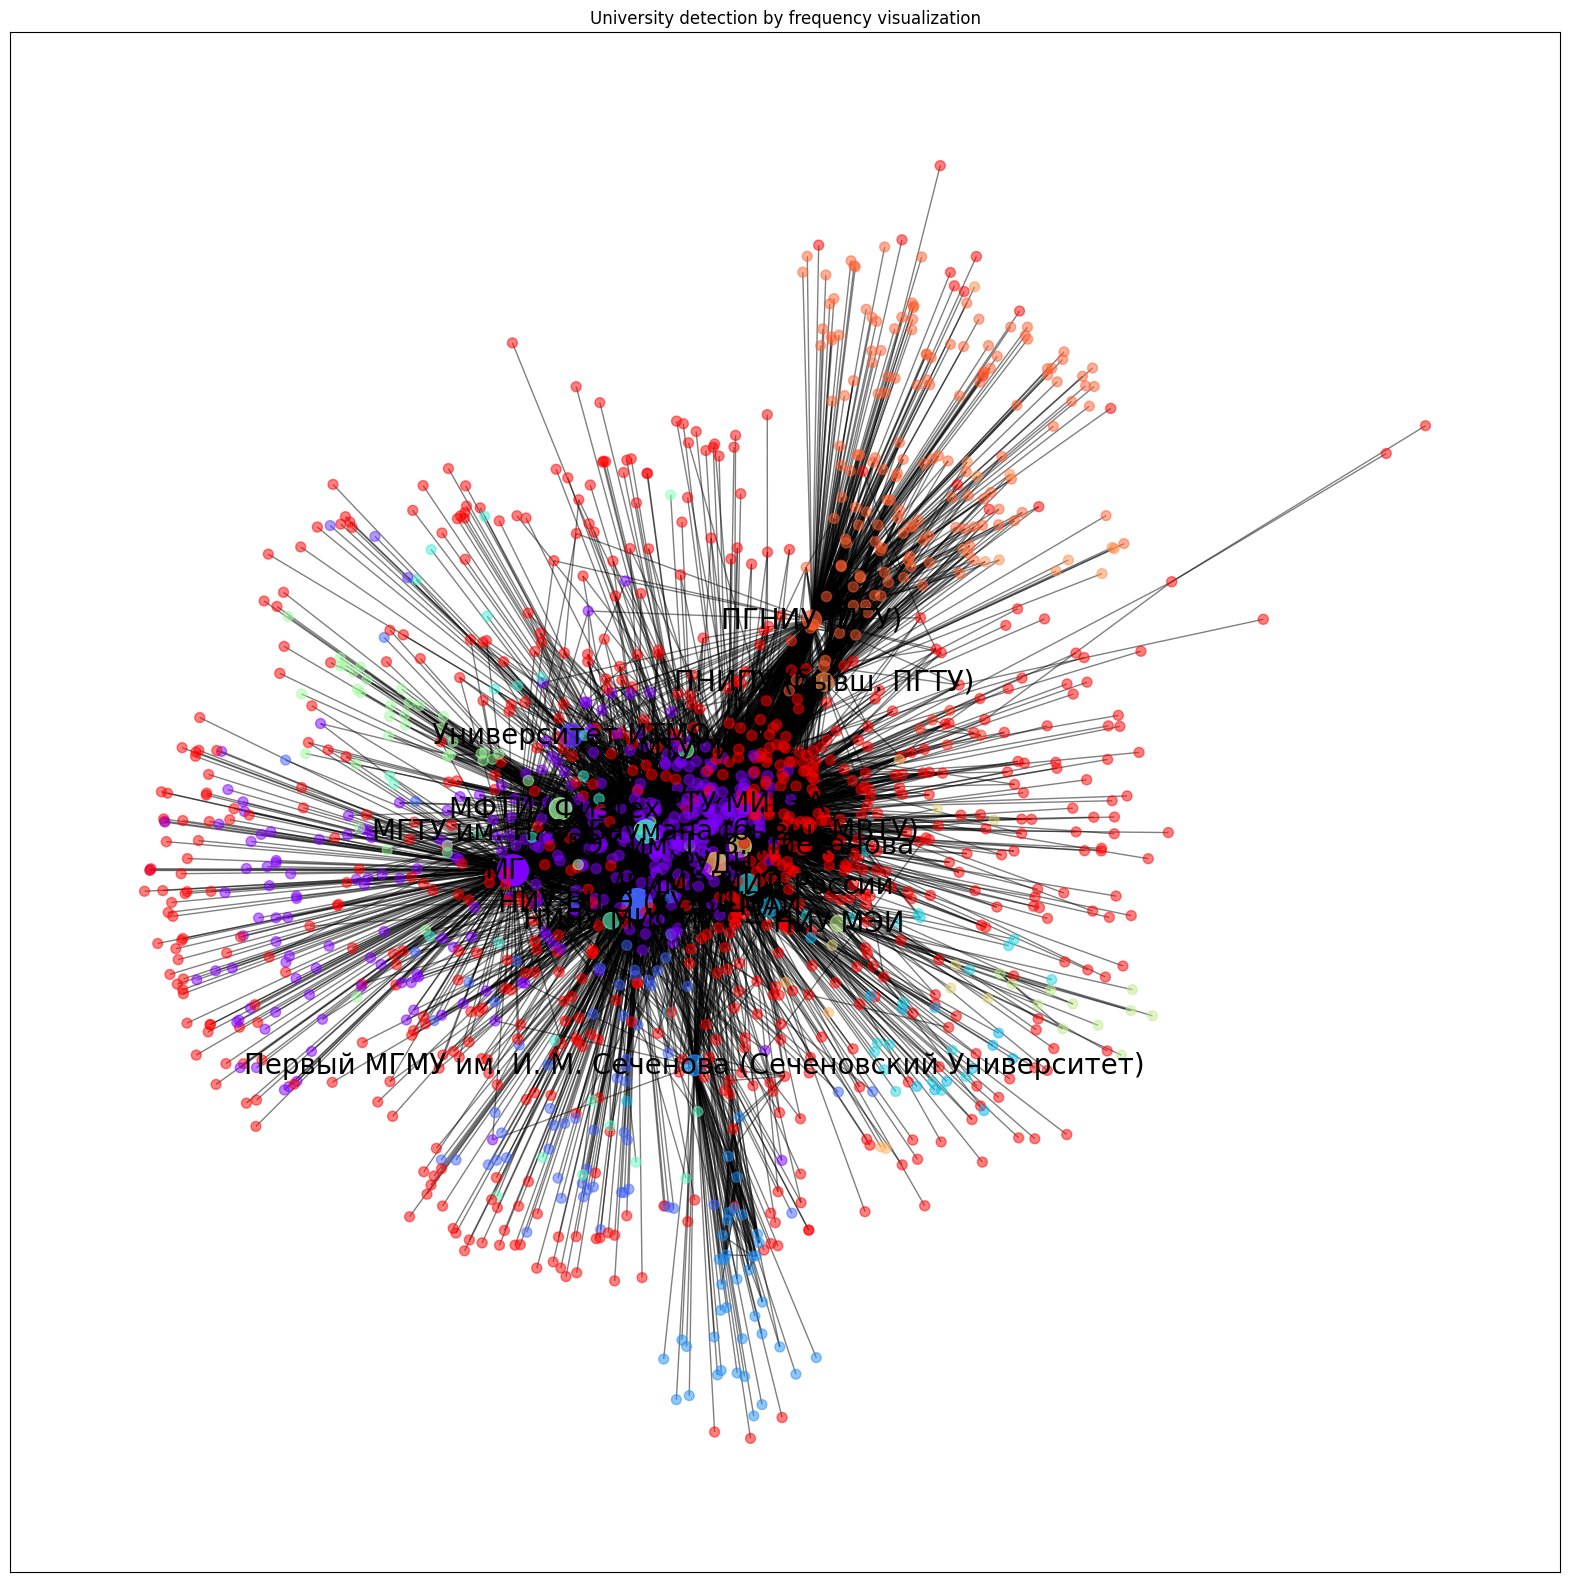

In [280]:
labels = {node: data['university'] for node, data in g.nodes(data=True) if data['is_main_group'] == 1}

plt.figure(figsize=(20, 20))
nx.draw_networkx_edges(g, pos, alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_size=sizes, node_color=colors, cmap=plt.cm.rainbow, alpha=alpha)
nx.draw_networkx_labels(g, pos, labels, font_size=20, font_family='sans-serif', font_color = "k")
plt.title('University detection by frequency visualization')
plt.show()

In [219]:
nodes[nodes['university'] == 'МГУ']

id                                   name is_main_group  \
0      78019879               МГУ имени М.В.Ломоносова             t   
1     204636234  Механико-математический факультет МГУ             f   
2      46581711         Студенческий cовет Биофака МГУ             f   
3      59592700                          Признания МГУ             f   
4      54295855                       Подслушано в МГУ             f   
...         ...                                    ...           ...   
1106   41827660   Daily English: английский по фильмам             f   
1113     998490                               Репортёр             f   
1133   37752959                Французский для лентяев             f   
1134   41538339                Практическая психология             f   
1349   39236499                     Частное сообщество             f   

      sub_quantity  university_id  MGU_quantity  MIFI_quantity  SECH_quantity  \
0            13121            2.0          1042             18              5   
1               25            2.0            20              0              0   
2               21            2.0            21              0              0   
3              150            2.0           136              1              0   
4              345            2.0           301              2              0   
...            ...            ...           ...            ...            ...   
1106           122            NaN            20              2             11   
1113           101            NaN            22              3              0   
1133            89            NaN            18              5              2   
1134           227            NaN            16              7             11   
1349            84            NaN            18              1              0   

      MEI_quantity  MGIMO_quantity  ...  PGNIU_quantity  RUDN_quantity  \
0               11              28  ...              23             15   
1                0               0  ...               0              0   
2                0               0  ...               0              0   
3                0               2  ...               0              0   
4                0               7  ...               1              0   
...            ...             ...  ...             ...            ...   
1106             2              11  ...              13              9   
1113             2              11  ...               6              8   
1133             1              10  ...               5              8   
1134             5              14  ...              33             21   
1349             2               8  ...               6              4   

      ITMO_quantity  REU_quantity  MGTU_quantity  MFTI_quantity  \
0                 4            17             23             12   
1                 1             0              1              1   
2                 0             0              0              0   
3                 0             0              3              4   
4                 0             3              5              7   
...             ...           ...            ...            ...   
1106              4             9              7              5   
1113              3             6              1              4   
1133              0             8              3              6   
1134              9            26             11              4   
1349              4             3              2              4   

      open_sub_quantity  university  is_main_group_int  university_encoder  
0                  1269         МГУ                  1                   3  
1                    25         МГУ                  0                   3  
2                    21         МГУ                  0                   3  
3                   150         МГУ                  0                   3  
4                   345         МГУ                  0                   3  
...                

In [283]:
def build_graph(node_df, edge_df):

    G = nx.Graph()
    for _, row in node_df.iterrows():
        university = row['custom_university_id']
        if pd.isnull(row['custom_university_id']):
            university = np.nan
        else: 
            university = int(row['custom_university_id'])
        
        G.add_node(row['custom_id'], name = row['name'], university=university, is_main_group=int(row['is_main_group_int']), sub_quantity=int(row['sub_quantity']))

    for _, row in edge_df.iterrows():
        if row['vk1_custom_id'] in G.nodes and row['vk2_custom_id'] in G.nodes:
            G.add_edge(row['vk1_custom_id'], row['vk2_custom_id'], weight=int(row['Quantity']))

    return G

nodes = pd.read_csv("dataset/nodes.csv", delimiter= ';')
edges = pd.read_csv("dataset/edges.csv", delimiter= ';')
graph = build_graph(nodes, edges)


train_nodes = pd.read_csv("dataset/testnodes.csv", delimiter= ';')
train_edges = pd.read_csv("dataset/testedges.csv", delimiter= ';')
train_graph = build_graph(train_nodes, train_edges)

valid_nodes = pd.read_csv("dataset/validnodes.csv", delimiter= ';')
valid_edges = pd.read_csv("dataset/validedges.csv", delimiter= ';')
valid_graph = build_graph(valid_nodes, valid_edges)

In [285]:
def prepare_data(graph):
    node_features = []
    node_labels = []
    for node in graph.nodes(data=True):
        features = [node[1]['is_main_group'], node[1]['sub_quantity']]
        label = node[1]['university']
        node_features.append(features)
        node_labels.append(label)
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(node_labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

train_data = prepare_data(train_graph)
valid_data = prepare_data(valid_graph)

In [286]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(num_node_features=train_data.num_features, num_classes=len(set(train_data.y.tolist())))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [290]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out[train_data.train_mask], train_data.y[train_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Проверка модели на валидационных данных
def test(data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc = correct / data.val_mask.sum().item()
    return acc

# Метки для обучения и валидации
train_mask = torch.ones(train_data.num_nodes, dtype=torch.bool)
train_data.train_mask = train_mask
val_mask = torch.ones(valid_data.num_nodes, dtype=torch.bool)
valid_data.val_mask = val_mask

for epoch in range(200):
    loss = train()
    valid_acc = test(valid_data)
    print(f'Epoch {epoch}, Loss: {loss}, Validation Accuracy: {valid_acc}')

Epoch 0, Loss: 4.750731468200684, Validation Accuracy: 0.2696629213483146
Epoch 1, Loss: 6.230708599090576, Validation Accuracy: 0.3258426966292135
Epoch 2, Loss: 6.213557243347168, Validation Accuracy: 0.3146067415730337
Epoch 3, Loss: 4.959473133087158, Validation Accuracy: 0.23595505617977527
Epoch 4, Loss: 5.5937042236328125, Validation Accuracy: 0.21348314606741572
Epoch 5, Loss: 5.629580497741699, Validation Accuracy: 0.2247191011235955
Epoch 6, Loss: 5.632880687713623, Validation Accuracy: 0.30337078651685395
Epoch 7, Loss: 5.5257439613342285, Validation Accuracy: 0.3146067415730337
Epoch 8, Loss: 6.049563407897949, Validation Accuracy: 0.33707865168539325
Epoch 9, Loss: 5.476760387420654, Validation Accuracy: 0.25842696629213485
Epoch 10, Loss: 6.071061611175537, Validation Accuracy: 0.25842696629213485
Epoch 11, Loss: 5.345504283905029, Validation Accuracy: 0.3146067415730337
Epoch 12, Loss: 5.469584941864014, Validation Accuracy: 0.3146067415730337
Epoch 13, Loss: 5.651776790

In [291]:
def fill_missing_values(graph, model):
    model.eval()
    node_features = []
    nodes = list(graph.nodes(data=True))
    for node in nodes:
        features = [node[1]['is_main_group'], node[1]['sub_quantity']]
        node_features.append(features)
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    data = Data(x=x, edge_index=edge_index)
    out = model(data)
    pred = out.argmax(dim=1)
    for idx, node in enumerate(nodes):
        if pd.isna(node[1]['university']):
            node[1]['university'] = pred[idx].item()

fill_missing_values(graph, model)


In [292]:
graph.remove_nodes_from([1574, 1555, 1565, 1579, 1547,1552])
graph.remove_nodes_from(list(nx.isolates(graph)))

In [293]:

nodes_data = dict(graph.nodes(data=True))
df = pd.DataFrame.from_dict(nodes_data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'node'}, inplace=True)

df

node                               name  university  is_main_group  \
0      970  Generation Brand & Communications          16              0   
1        3          МГУ имени М.В. Ломоносова           0              0   
2      248          Факультет политологии МГУ           0              0   
3      874     Студенческий cовет Биофака МГУ           0              0   
4      956                    Профком ВМК МГУ           0              0   
...    ...                                ...         ...            ...   
1572    29                          ФМХФ МФТИ           9              0   
1573    31                          ФАКТ МФТИ           9              0   
1574   925                      Время Физтеха          16              0   
1575    95                            лайфхак          16              0   
1576  1070                    Подслушано ИТМО           1              0   

      sub_quantity  
0               26  
1               91  
2               26  
3               21  
4               28  
...            ...  
1572            23  
1573            26  
1574            26  
1575            39  
1576            33  

[1577 rows x 5 columns]

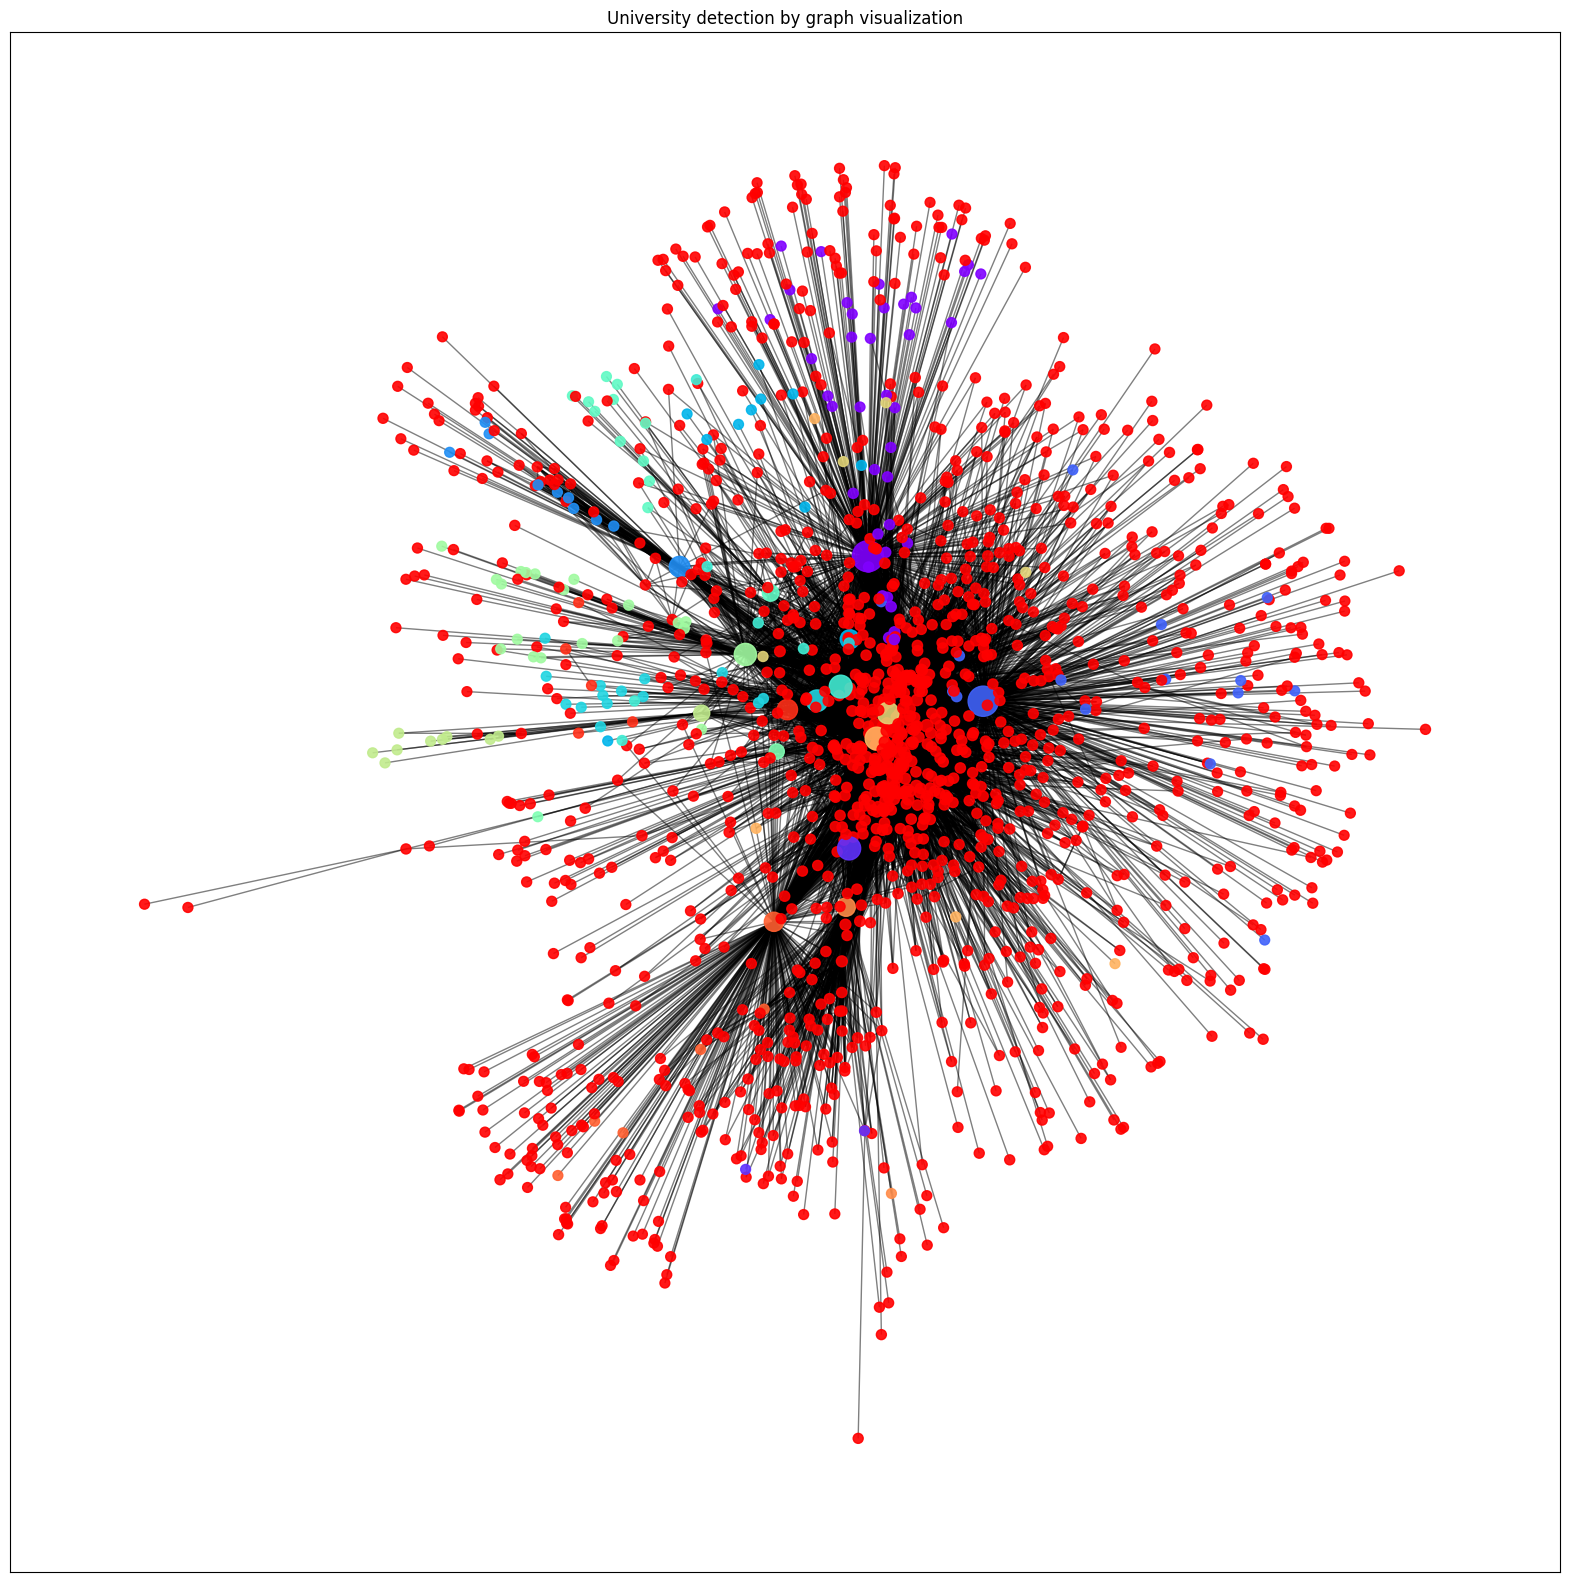

In [294]:
pos = nx.spring_layout(graph)

colors = [graph.nodes[node]['university'] for node in graph.nodes()]
sizes =  [normalize(graph.nodes[node]['sub_quantity'], min_q, max_q, 50, 500) for node in graph.nodes()]
alpha =  [normalize(graph.nodes[node]['sub_quantity'], min_q, max_q, 0.5, 1) for node in graph.nodes()]

plt.figure(figsize=(20, 20))
nx.draw_networkx_edges(graph, pos, alpha=0.5)
nx.draw_networkx_nodes(graph, pos, node_size=sizes, node_color=colors, cmap=plt.cm.rainbow, alpha=0.9)
plt.title('University detection by graph visualization')
plt.show()